# Molecular docking via DC-QAOA  

rugs often work by binding to an active site of a protein, inhibiting or activating tis function for some therapeutic purpose. Finding new candidate drugs is extremely difficult. The study of molecular docking helps guidd this search and involves the prediction of how strongly a certain ligan (drug) will bind to tis target (usually a protein)  

One of the primary challenges to molecular docking arises from the many geometric degrees of freedom presnet in proteins and ligands, making it difficult to predict the optimal orientation and assess if the drug is a good candidate or not. One solutiong is to formulate the problem as mathematical optimization problem where the optimal solution corresponeds to the most likely ligand-protein configuration. This optimization problem can be solved on a quantum computer using methods like the QAOA. This example demonstrates DC(digitized-counteradiabatic) QAOA to study molecular docking. It assumes you have an understanding of QAOA, if not, please see the CUDA-Q MaxCut.

## Setting up the Molecular Docking Problem  
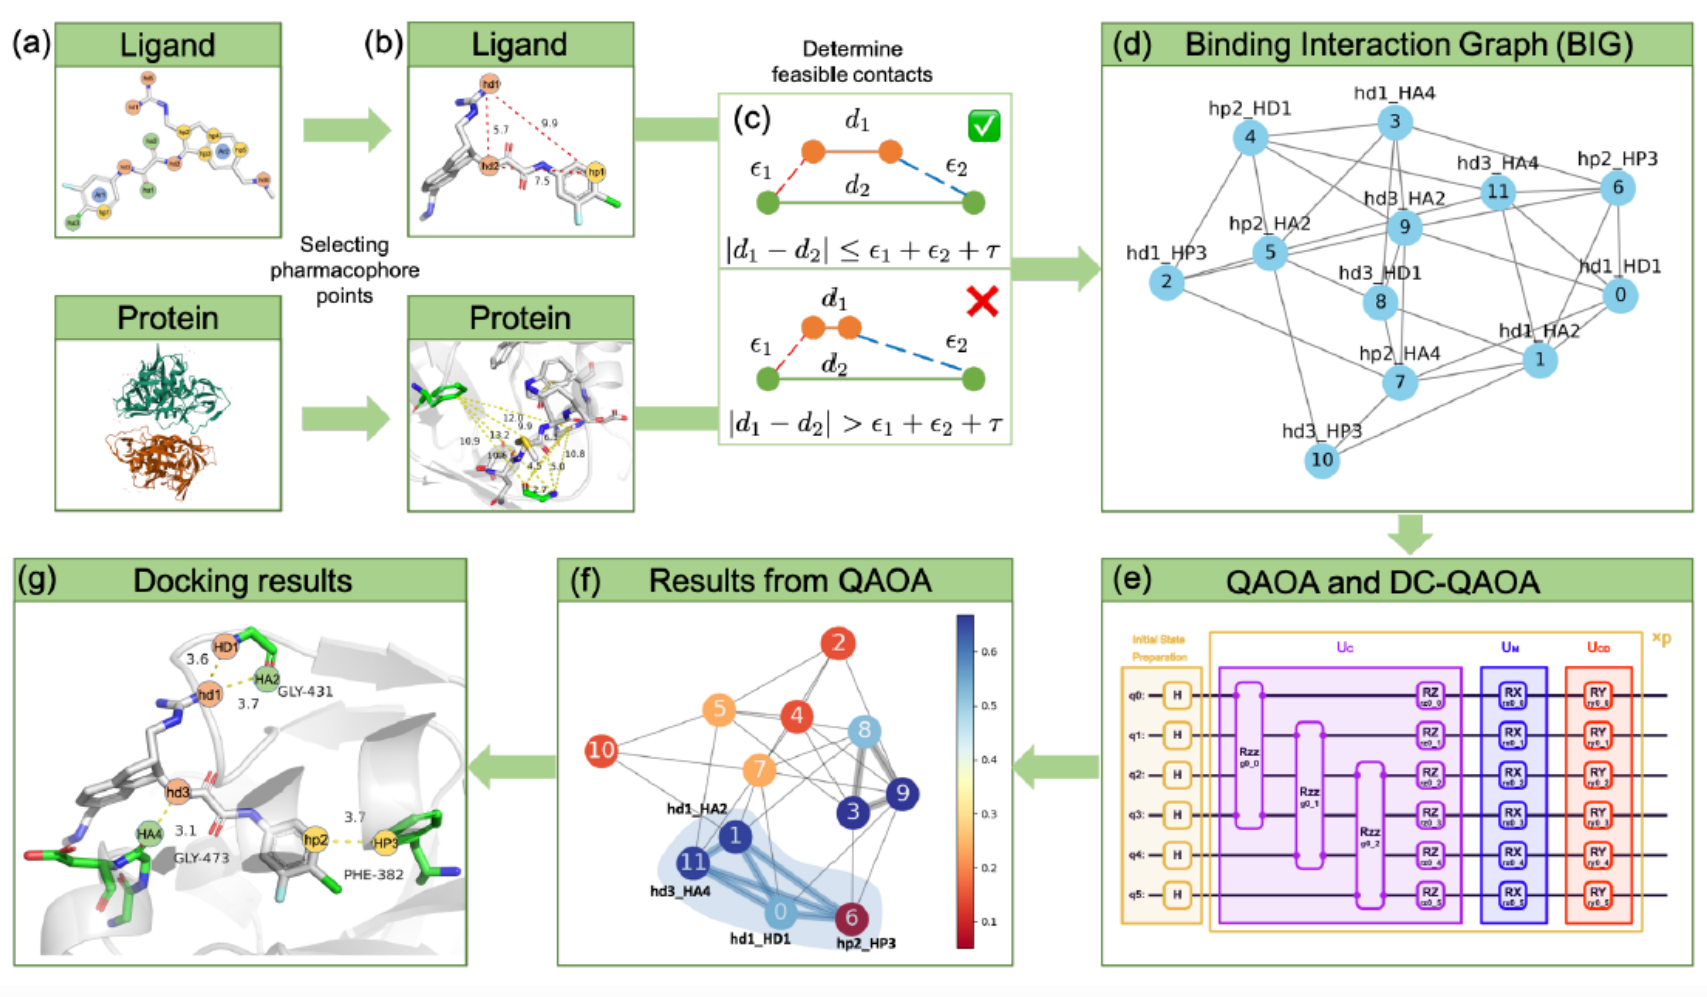  

There are 6 key steps: 1. The experimental protein and ligand structures are determined and used to select pharmacores, or an important chemical group that will govern the chemical interactions. 2. Two labeled distance graphs (LAGs) of size %N$ and $M$ represent the protein and ligand, respectively. Each node corresponds to a pharmacore and each ege weight corresponds to the distance b/w pharamacores. 3. A $M*N$ node binding interactiong graph (BIG) is created from the LAGs. Each node in the BIG graph corresponds to a pair of pharmacores, one from the ligand and the other from the proteim. The existence of edges b/w nodes in the BIG graph are determined from the LAGs and correspond to interactions that can feesibly coexist. Therefore, cliques in the graph correspond to mutually possible interatctions. 4. The problem is mapped to a QAOA circuit and corresponding Hamiltonian. From there the ground state solution is determined. 5. The ground state will produce the maximum weighted clique which corresponds to the best (most strongly bound) orientation of the ligand and protein. 6. The predicted docking structure is interpreted from the QAOA result and is used for futher analysis


## CUDA-Q Implementation

In [1]:
import cudaq
from cudaq import spin
import numpy as np

The block below defines two of the BIG data sets. The first is a smaller example, but it can be swapped with the commented out example below at your direction. The weights are specified for each node based on the nature of the ligand and protein pharmacores represented by the node

In [2]:
nodes = [0, 1, 2, 3, 4, 5]
qubit_num = len(nodes)
edges = [[0, 1], [0, 2], [0, 4], [0, 5], [1, 2], [1, 3], [1, 5], [2, 3], [2, 4],
         [3, 4], [3, 5], [4, 5]]
non_edges = [[u, v] for u in nodes for v in nodes if u < v and [u, v] not in edges]

print("Edges:", edges)
print("Non-edges:", non_edges)

weights = [0.6686, 0.6686, 0.6686, 0.1453, 0.1453, 0.1453]
penalty = 6.0
num_layers = 3


# BIG 2 (More expensive simulation)
#nodes=[0,1,2,3,4,5,6,7]
#qubit_num=len(nodes)
#edges=[[0,1],[0,2],[0,5],[0,6],[0,7],[1,2],[1,4],[1,6],[1,7],[2,4],[2,5],[2,7],[3,4],[3,5],[3,6],\
#    [4,5],[4,6],[5,6]]
#non_edges=[[u,v] for u in nodes for v in nodes if u<v and [u,v] not in edges]
#print('Edges: ', edges)
#print('Non-edges: ', non_edges)
#weights=[0.6686,0.6686,0.6886,0.1091,0.0770,0.0770,0.0770,0.0770]
#penalty=8.0
#num_layers=8

Edges: [[0, 1], [0, 2], [0, 4], [0, 5], [1, 2], [1, 3], [1, 5], [2, 3], [2, 4], [3, 4], [3, 5], [4, 5]]
Non-edges: [[0, 3], [1, 4], [2, 5]]


Next, the Hamiltonian is constructed:
$$H = \frac{1}{2} \sum_{i\subseteq V}{\omega_i(\sigma_i^z-1)} + \frac{P}{4} \sum_{(i,j)\notin E, i\neq j}{(\sigma_i^z-1)(\sigma_j^z-1)} $$

The first term concerns the vertices and the weights of the given pharmacores. The second term is a penalty term that penalized edges of the pgrah with no interactions. The penalty $P$ is set by the user and is defined as 6 in the cell above. The function below returns the Hamiltonian as a CUDA-Q ```spin_op``` object

In [62]:
@cudaq.kernel
def a():
    qubit = cudaq.qvector(1)
    h(qubit)
    rz(np.pi, qubit[0])

print(cudaq.observe(a, spin.x(0)).expectation())

-0.9999999403953552


In [68]:
words = ['ZZ']
coefficients = [np.pi/2] # 얘는 사실 pi만큼 회전임. 왜냐면 rzz가 1/2 곱해져서 들어가니까.


@cudaq.kernel
def kernel(coefficients: list[float], words: list[cudaq.pauli_word]):
    q = cudaq.qvector(2)
    h(q)

    for i in range(len(coefficients)):
        exp_pauli(coefficients[i], q, 'words[i]')
    
print(cudaq.observe(kernel, spin.x(0), coefficients, words).expectation())



-0.9999998807907104


In [60]:
import numpy as np

# cudaq.register_operation("custom_x", np.array([0, 1, 1, 0]))
cudaq.register_operation("xc", np.array([[1,0,0,0],
                                         [0,1,0,0],
                                         [0,0,0,1],
                                         [0,0,1,0]]))

cudaq.register_operation("rzz", np.array([[np.exp(-1j * np.pi / 2 ),0,0,0],
                                         [0,np.exp(1j * np.pi / 2),0,0],
                                         [0,0,np.exp(1j * np.pi / 2),1],
                                         [0,0,1,np.exp(-1j * np.pi / 2)]]))

# custom operator 확인

@cudaq.kernel 
def kernel():
    qubits = cudaq.qvector(2)
    h(qubits)
    # custom_x(qubits[0])
    # custom_x.ctrl(qubits[0], qubits[1])
    rzz(qubits[0],qubits[1])

# cudaq.sample(kernel).dump()
print(cudaq.observe(kernel, spin.x(0)).expectation())

-0.9999998807907104


In [4]:
@cudaq.kernelb
def k(thetas):
    exp_pauli(thetas, qubits, words[i])

NameError: name 'exp_pauli' is not defined

In [3]:
def ham_clique(penalty, nodes, weights, non_edges) -> cudaq.SpinOperator:

    spin_ham = 0
    for wt, node in zip(weights, nodes):
        #print(wt,node)
        spin_ham += 0.5 * wt * spin.z(node)
        spin_ham -= 0.5 * wt * spin.i(node)

    for non_edge in non_edges:
        u, v = (non_edge[0], non_edge[1])
        #print(u,v)
        spin_ham += penalty / 4.0 * (spin.z(u) * spin.z(v) - spin.z(u) -
                                     spin.z(v) + spin.i(u) * spin.i(v))


    return spin_ham